In [2]:
!nvidia-smi

Fri Aug 18 07:52:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
import json
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/New folder

/content/drive/MyDrive/New folder


In [4]:
df = pd.read_csv("final_details.csv")


In [5]:
df=df.drop_duplicates(subset=['url'])
df = df[df.types != '[]']
df.describe()

,title,url,description,types
count,18397,18397,18396,18397
unique,17332,18397,14719,17254
top,Paella,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,30 mins,"['None', 'low-carb']"
freq,24,1,320,157


In [13]:
df = df.dropna().reset_index(drop=True)
df.shape

(18396, 4)

In [14]:
import ast

for i in range(len(df.types)):
  try:
    list_1 = ast.literal_eval(df.types[i])
    if isinstance(list_1, list):
      df.types[i] = list_1
  except (ValueError, SyntaxError):
    pass

In [15]:
 types_list = df.types.to_list()

In [16]:
mapping = {
    'Onion': 'Vegetable',
    'Poultry': 'Chicken',
    'saltwater\xa0Fish': 'saltwater fish',
    'Root Vegetable': 'Vegetable'
}

for sublist in types_list:
    for i in range(len(sublist)):
        sublist[i] = mapping.get(sublist[i], sublist[i])

types_list[1]

['Finger Food',
 'Fitness',
 'Tapas',
 'Low-calorie',
 'low-carb',
 'Healthy Eating',
 'Pescetarian',
 'Buffet',
 'leafy green vegetable',
 'Low-calorie Meat Dish',
 'non-alcoholic',
 'Fruit',
 'Garden Party',
 'Picnic',
 'Brunch',
 'Vegetable',
 '25-Minute',
 'Meal for Four',
 'Herb',
 'festively',
 'Exotic',
 'Low-cholesterol',
 '250-400 Calorie',
 'Special',
 'Party',
 'Appetizer',
 'Fish',
 'Dairy',
 'Snack',
 'egg-free',
 'Party Snack']

In [19]:
for sublist in types_list:
    new_sublist = []
    for item in sublist:
        if item not in ['Party Snack','Pescetarian','Picnic','Garden Party','Party','Stomach Discomfort','everyday meal','Elevated Blood Lipid','Crohn&#039;s Disease','European','Course','Main Course''Meal for Four','Menu', 'Guest', 'Easy', 'Lactation', 'Quick','Cooking','Osteoarthritis','Stress','Iron Deficiency','Cooking on vacation','Pregnancy','Fertility']:
            new_sublist.append(item)
    sublist[:] = new_sublist
types_list[1]

['Finger Food',
 'Fitness',
 'Tapas',
 'Low-calorie',
 'low-carb',
 'Healthy Eating',
 'Buffet',
 'leafy green vegetable',
 'Low-calorie Meat Dish',
 'non-alcoholic',
 'Fruit',
 'Brunch',
 'Vegetable',
 '25-Minute',
 'Meal for Four',
 'Herb',
 'festively',
 'Exotic',
 'Low-cholesterol',
 '250-400 Calorie',
 'Special',
 'Appetizer',
 'Fish',
 'Dairy',
 'Snack',
 'egg-free']

In [20]:
for i in range (len(types_list)):
  types_list[i]=types_list[i][:5]

types_list[1]

['Finger Food', 'Fitness', 'Tapas', 'Low-calorie', 'low-carb']

In [21]:
for sublist in types_list:
    sublist[:] = list(set(sublist))
types_list[1]

['Finger Food', 'Fitness', 'Tapas', 'Low-calorie', 'low-carb']

In [22]:
df.types=types_list

In [23]:
df

,title,url,description,types
0,Cucumber Sandwiches with Fresh Goat Cheese,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,"Due to the high water content, the vegetables are very helpful for weight loss. 100 grams of cucumber provide just 12 calories. Cucumbers also contain potassium, iron, zinc, fluorine, and some vitamin C. With the goat's cheese comes satiating protein between the slices.","[Cheese, low-carb, Vegetable]"
1,Smoked Trout Tartare with Avocado Mango Salsa,https://eatsmarter.com/recipes/smoked-trout-tartare-with-avocado-mango-salsa,"The sulfur substances contained in chives are responsible for their slight pungency. They provide a slight antibacterial effect and have a positive effect on digestion. If things run smoothly in the intestines, our concentration is also ensured. This is also supported by the omega-3 fatty acids from the smoked salmon trout.","[Finger Food, Fitness, Tapas, Low-calorie, low-carb]"
2,Basic Tofu Recipe,https://eatsmarter.com/recipes/basic-tofu-recipe,"Do you have a sensitive stomach? Then tofu is perfect for you, because it's easy on the stomach and doesn't put a strain on digestion. Great veggie option: With around 15 percent vegetable protein, soy cheese gives us about as much as most types of meat offer.","[Soy, low-carb, Mineral-rich, Healthy Eating, High-protein]"
3,Grilled Watermelon with Herbed Ricotta,https://eatsmarter.com/recipes/grilled-watermelon-with-herbed-ricotta,"Despite the fruity-sweet taste of Watermelons there is relatively little sugar in it. On top, the fruit provides plenty of liquid for a refreshing feast on hot summer days. Essential oils from Cress help to get disease-causing bacteria under control. For example, cold symptoms can subside more quickly.","[low-carb salad, Vegetarian Appetizers, low-carb, Healthy Eating, Vegetarian Snack]"
4,Egg Bites with Smoked Salmon and Broccoli,https://eatsmarter.com/recipes/egg-bites-with-smoked-salmon-and-broccoli,"Eggs contain a lot of biotin. This B vitamin promotes hair growth and a healthy nail bed. In addition, the substance is needed for all metabolic processes in the organism.","[Finger Food, Autumn, low-carb, Summer, Gluten-free Snack]"
...,...,...,...,...
18391,Sausage and Ham Croissants,https://eatsmarter.com/recipes/sausage-and-ham-croissants,Roll the dough on a lightly floured surface to 4-5 mm (approximately 1/8 inch) thick. Cut into 3 cm (approximately 1 1/4 inch) wide and 20 cm (approximately 8 inch) long strips.,"[Breakfast, Pork, Grain, 250-400 Calorie, Milk]"
18392,Shakshuka with Eggplant,https://eatsmarter.com/recipes/shakshuka-with-eggplant,This delicious vegetable and egg shakshuka dish is packed with a slew of vitamins and minerals thanks to the vegetable mixture as well as powerful protein from the eggs. Shakshukas are versatile and are a complete meal,"[Breakfast, Sunday cooking, Tunisian, What to Cook on the Weekend?, baked dish]"
18393,Currant Jelly,https://eatsmarter.com/recipes/currant-jelly-1,"Remove the jelly from the pan, and place on a long platter. Serve with bread and cheese.","[Breakfast, fat-free, non-alcoholic, Vegetarian, Sweet Breakfast]"
18394,Multi-Grain Walnut Bread,https://eatsmarter.com/recipes/multi-grain-walnut-bread,"Add both flours, the shredded wheat, ground walnuts and salt and knead with the dough hook until smooth. Cover and let rise in a warm place until doubled in bulk, about 45 minutes.","[Breakfast, Grain, Yeast Dough, Bread Dough, crowdpleaser]"


In [24]:
types_list = df.types.to_list()
type_count = {}
for type1 in types_list:
  if isinstance(type1, list):
    type_list = type1
  else:
    type_list = eval(type1)
  for type2 in type_list:
    if type2 in type_count.keys():
      type_count[type2] += 1
    else:
      type_count[type2] = 1
print(f"Number of types: {len(type_count)}")
print(type_count)

Number of types: 938
{'Cheese': 468, 'low-carb': 5341, 'Vegetable': 3582, 'Finger Food': 358, 'Fitness': 170, 'Tapas': 80, 'Low-calorie': 448, 'Soy': 179, 'Mineral-rich': 454, 'Healthy Eating': 725, 'High-protein': 522, 'low-carb salad': 97, 'Vegetarian Appetizers': 410, 'Vegetarian Snack': 85, 'Autumn': 826, 'Summer': 54, 'Gluten-free Snack': 1, 'Lactose-free Snacks': 24, 'Vegan Snack': 76, 'winter': 355, 'Snack for Kids': 39, 'birthday for kids': 26, 'Clean Eating': 464, 'Special': 41, 'South America': 86, 'Gut Flora': 893, 'Irritable Bowel Syndrome': 792, 'Healthy Eyes': 636, 'Sweet Breakfast': 277, 'Meal for Two': 361, 'Lunch': 257, 'nutritional': 29, 'Dinner': 339, 'eating at work': 149, 'What to Cook Today?': 276, 'Alkaline': 17, 'Low-cholesterol': 63, 'Spring Dish': 113, 'Spring': 590, 'Fruit': 1531, 'low-carb fish': 186, 'Cooking technique': 17, 'high cholesterol': 183, 'non-alcoholic': 659, 'Beef Stroganoff': 4, 'Beef': 517, 'mushroom': 537, 'Grandma&#039;s': 55, 'High-protein

In [25]:
threshold = int(len(df) * 0.02)
rare_types = [key for key, value in type_count.items() if value < threshold]
len(rare_types), rare_types[:10]

(883,
 ['Finger Food',
  'Fitness',
  'Tapas',
  'Soy',
  'low-carb salad',
  'Vegetarian Snack',
  'Summer',
  'Gluten-free Snack',
  'Lactose-free Snacks',
  'Vegan Snack'])

In [26]:
types_list
revised_types_list = []
indices_to_drop = []

for idx, types in enumerate(types_list):
  if isinstance(types, list):
    type_list = types
  else:
    type_list = eval(types)

  revised_types = []

  for type1 in type_list:
    if type1 not in rare_types:
      revised_types.append(type1)

  if len(revised_types) == 0:
    indices_to_drop.append(idx)
  else:
    revised_types_list.append(revised_types)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(18185, 4)

In [27]:
df['revised_types'] = revised_types_list

In [28]:
df.tail()

,title,url,description,types,revised_types
18180,Sausage and Ham Croissants,https://eatsmarter.com/recipes/sausage-and-ham-croissants,Roll the dough on a lightly floured surface to 4-5 mm (approximately 1/8 inch) thick. Cut into 3 cm (approximately 1 1/4 inch) wide and 20 cm (approximately 8 inch) long strips.,"[Breakfast, Pork, Grain, 250-400 Calorie, Milk]","[Breakfast, Pork, Grain]"
18181,Shakshuka with Eggplant,https://eatsmarter.com/recipes/shakshuka-with-eggplant,This delicious vegetable and egg shakshuka dish is packed with a slew of vitamins and minerals thanks to the vegetable mixture as well as powerful protein from the eggs. Shakshukas are versatile and are a complete meal,"[Breakfast, Sunday cooking, Tunisian, What to Cook on the Weekend?, baked dish]",[Breakfast]
18182,Currant Jelly,https://eatsmarter.com/recipes/currant-jelly-1,"Remove the jelly from the pan, and place on a long platter. Serve with bread and cheese.","[Breakfast, fat-free, non-alcoholic, Vegetarian, Sweet Breakfast]","[Breakfast, non-alcoholic, Vegetarian]"
18183,Multi-Grain Walnut Bread,https://eatsmarter.com/recipes/multi-grain-walnut-bread,"Add both flours, the shredded wheat, ground walnuts and salt and knead with the dough hook until smooth. Cover and let rise in a warm place until doubled in bulk, about 45 minutes.","[Breakfast, Grain, Yeast Dough, Bread Dough, crowdpleaser]","[Breakfast, Grain]"
18184,Homemade Red Currant Jelly,https://eatsmarter.com/recipes/homemade-red-currant-jelly,"Bring the mixture to a boil, and cook for 4 minutes. Fill the jelly into the sterilized prepared jars. Seal tightly, and turn upside down for 15 minutes. Turn right side up and cool completely.","[Breakfast, Fruit, Sweet Breakfast, Red Currant Jelly, Home Cooking]","[Breakfast, Fruit, Home Cooking]"


In [29]:
revised_types_list = df.revised_types.to_list()
revised_types_list

[['Cheese', 'low-carb', 'Vegetable'],
 ['Low-calorie', 'low-carb'],
 ['low-carb', 'Mineral-rich', 'Healthy Eating', 'High-protein'],
 ['Vegetarian Appetizers', 'low-carb', 'Healthy Eating'],
 ['Autumn', 'low-carb'],
 ['Autumn', 'low-carb'],
 ['Clean Eating'],
 ['Gut Flora', 'Irritable Bowel Syndrome', 'Healthy Eyes', 'low-carb'],
 ['Autumn', 'low-carb', 'High-protein'],
 ['low-carb', 'Healthy Eating'],
 ['low-carb', 'Mineral-rich'],
 ['Spring', 'Fruit', 'low-carb'],
 ['Gut Flora', 'Irritable Bowel Syndrome', 'Healthy Eyes', 'low-carb'],
 ['Low-calorie'],
 ['non-alcoholic', 'Gut Flora', 'low-carb', 'Mineral-rich'],
 ['Beef', 'mushroom', 'low-carb'],
 ['Clean Eating'],
 ['Gout', 'Autumn', 'Vegetarian Appetizers', 'Low-calorie'],
 ['Irritable Bowel Syndrome', 'Healthy Eyes', 'low-carb', 'Mineral-rich'],
 ['Gout', 'Gut Flora', 'Low-calorie'],
 ['Seafood', 'Clean Eating'],
 ['mushroom', 'Clean Eating', 'Autumn'],
 ['low-carb'],
 ['Autumn', 'low-carb'],
 ['flowering vegetables', 'Autumn', 'S

In [30]:
revised_types_list
revised_type_count = {}
for types in revised_types_list:
  type_list = types
  for type1 in type_list:
    if type1 in revised_type_count.keys():
      revised_type_count[type1] += 1
    else:
      revised_type_count[type1] = 1
print(f"Number of types: {len(revised_type_count)}")
print(revised_type_count)

Number of types: 55
{'Cheese': 468, 'low-carb': 5341, 'Vegetable': 3582, 'Low-calorie': 448, 'Mineral-rich': 454, 'Healthy Eating': 725, 'High-protein': 522, 'Vegetarian Appetizers': 410, 'Autumn': 826, 'Clean Eating': 464, 'Gut Flora': 893, 'Irritable Bowel Syndrome': 792, 'Healthy Eyes': 636, 'Spring': 590, 'Fruit': 1531, 'non-alcoholic': 659, 'Beef': 517, 'mushroom': 537, 'Gout': 597, 'Seafood': 812, 'flowering vegetables': 588, 'Side Dish': 572, 'Vegetarian': 1354, 'Dessert': 2240, 'Mediterranean': 367, 'Breakfast': 500, 'Side Salad': 379, 'fruit-vegetable': 2016, 'Vegetable Salad': 1008, 'Baking': 961, 'Chicken': 1547, 'Sauce': 745, 'Meat': 966, 'Herb': 2177, 'Legume': 836, 'Roast': 923, 'saltwater fish': 945, 'Fish': 849, 'Shrimp': 614, 'Shellfish': 439, 'salad': 1339, 'Pork': 391, 'Home Cooking': 500, 'leafy green vegetable': 720, 'Spices': 801, 'Casserole': 582, 'Tropical Fruit': 598, 'soup': 417, 'Asian': 388, 'Fruit Dessert': 637, 'Grain': 394, 'Rice': 1515, 'Dough': 1297, 'd

In [31]:
revised_type_count.keys()

dict_keys(['Cheese', 'low-carb', 'Vegetable', 'Low-calorie', 'Mineral-rich', 'Healthy Eating', 'High-protein', 'Vegetarian Appetizers', 'Autumn', 'Clean Eating', 'Gut Flora', 'Irritable Bowel Syndrome', 'Healthy Eyes', 'Spring', 'Fruit', 'non-alcoholic', 'Beef', 'mushroom', 'Gout', 'Seafood', 'flowering vegetables', 'Side Dish', 'Vegetarian', 'Dessert', 'Mediterranean', 'Breakfast', 'Side Salad', 'fruit-vegetable', 'Vegetable Salad', 'Baking', 'Chicken', 'Sauce', 'Meat', 'Herb', 'Legume', 'Roast', 'saltwater fish', 'Fish', 'Shrimp', 'Shellfish', 'salad', 'Pork', 'Home Cooking', 'leafy green vegetable', 'Spices', 'Casserole', 'Tropical Fruit', 'soup', 'Asian', 'Fruit Dessert', 'Grain', 'Rice', 'Dough', 'dessert', 'Pasta'])

In [33]:
encode_types = { key: idx for idx, (key, value) in enumerate(revised_type_count.items())}
with open("recipe_types_encoded.json", "w") as fp:
  json.dump(encode_types, fp)

In [35]:
categorical_type_list = []
revised_types_list

for type5 in revised_types_list:
  categorical_list = [0] * len(encode_types)
  for type1 in type5:
    type1_index = encode_types[type1]
    categorical_list[type1_index] = 1
  categorical_type_list.append(categorical_list)

categorical_type_list[3][:45]

[0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [36]:
df['type_cat_list'] = categorical_type_list
df.head()

,title,url,description,types,revised_types,type_cat_list
0,Cucumber Sandwiches with Fresh Goat Cheese,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,"Due to the high water content, the vegetables are very helpful for weight loss. 100 grams of cucumber provide just 12 calories. Cucumbers also contain potassium, iron, zinc, fluorine, and some vitamin C. With the goat's cheese comes satiating protein between the slices.","[Cheese, low-carb, Vegetable]","[Cheese, low-carb, Vegetable]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Smoked Trout Tartare with Avocado Mango Salsa,https://eatsmarter.com/recipes/smoked-trout-tartare-with-avocado-mango-salsa,"The sulfur substances contained in chives are responsible for their slight pungency. They provide a slight antibacterial effect and have a positive effect on digestion. If things run smoothly in the intestines, our concentration is also ensured. This is also supported by the omega-3 fatty acids from the smoked salmon trout.","[Finger Food, Fitness, Tapas, Low-calorie, low-carb]","[Low-calorie, low-carb]","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Basic Tofu Recipe,https://eatsmarter.com/recipes/basic-tofu-recipe,"Do you have a sensitive stomach? Then tofu is perfect for you, because it's easy on the stomach and doesn't put a strain on digestion. Great veggie option: With around 15 percent vegetable protein, soy cheese gives us about as much as most types of meat offer.","[Soy, low-carb, Mineral-rich, Healthy Eating, High-protein]","[low-carb, Mineral-rich, Healthy Eating, High-protein]","[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Grilled Watermelon with Herbed Ricotta,https://eatsmarter.com/recipes/grilled-watermelon-with-herbed-ricotta,"Despite the fruity-sweet taste of Watermelons there is relatively little sugar in it. On top, the fruit provides plenty of liquid for a refreshing feast on hot summer days. Essential oils from Cress help to get disease-causing bacteria under control. For example, cold symptoms can subside more quickly.","[low-carb salad, Vegetarian Appetizers, low-carb, Healthy Eating, Vegetarian Snack]","[Vegetarian Appetizers, low-carb, Healthy Eating]","[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Egg Bites with Smoked Salmon and Broccoli,https://eatsmarter.com/recipes/egg-bites-with-smoked-salmon-and-broccoli,"Eggs contain a lot of biotin. This B vitamin promotes hair growth and a healthy nail bed. In addition, the substance is needed for all metabolic processes in the organism.","[Finger Food, Autumn, low-carb, Summer, Gluten-free Snack]","[Autumn, low-carb]","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [37]:
labels = list(encode_types.keys())

In [38]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [39]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('type_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [40]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "/content/drive/MyDrive/New folder/dataloaders/dls-multilabel-recipe-classifier12.pkl")

In [41]:
dls.vocab

['Cheese', 'low-carb', 'Vegetable', 'Low-calorie', 'Mineral-rich', 'Healthy Eating', 'High-protein', 'Vegetarian Appetizers', 'Autumn', 'Clean Eating', 'Gut Flora', 'Irritable Bowel Syndrome', 'Healthy Eyes', 'Spring', 'Fruit', 'non-alcoholic', 'Beef', 'mushroom', 'Gout', 'Seafood', 'flowering vegetables', 'Side Dish', 'Vegetarian', 'Dessert', 'Mediterranean', 'Breakfast', 'Side Salad', 'fruit-vegetable', 'Vegetable Salad', 'Baking', 'Chicken', 'Sauce', 'Meat', 'Herb', 'Legume', 'Roast', 'saltwater fish', 'Fish', 'Shrimp', 'Shellfish', 'salad', 'Pork', 'Home Cooking', 'leafy green vegetable', 'Spices', 'Casserole', 'Tropical Fruit', 'soup', 'Asian', 'Fruit Dessert', 'Grain', 'Rice', 'Dough', 'dessert', 'Pasta']

In [42]:
dls.show_batch(dataloaders=dls, max_n=10, trunc_at=256)

,text,target
0,"Rinse and trim zucchini, eggplant and bell peppers. Cut zucchini and eggplant into thin slices. Cut bell peppers in half, put on a baking sheet lined with parchment paper and toast under a preheated oven grill until skin begins to bubble and starts to tur","[fruit-vegetable, Casserole]"
1,Cut pumpkin flesh into thin slices. Set 8 of the slices aside and finely dice the rest. Sprinkle the slices with sugar and oil and wrap in aluminum foil. Season the diced pumpkin with salt and pepper and wrap in aluminum foil as well. Put both foil packet,"[Vegetable, flowering vegetables, Rice]"
2,"Rinse duck, pat dry and score skin in diamond pattern. Heat oil in a pan. Cook duck, skin side down, for about 5 minutes or until browned. Turn meat over and cook on another side for about 2 minutes. Season with salt and pepper. Put in a roasting pan and","[Chicken, Rice]"
3,"Rinse the meat, pat dry and cut a pocket into the side. Soak the bread in the milk and let stand for about 5 minutes. Rinse the peppers, cut in half, remove the stems, seeds and pith and finely chop. Peel the shallot, finely chop and sauté with the pepper","[low-carb, fruit-vegetable, Roast, Pork]"
4,"Peel 1 shallot and the garlic cloves, chop finely and cook in a hot pan with 20 grams (approximately 1 1/2 tablespoons) melted butter until translucent, 1-2 minutes. Mix ground meat with egg. Squeeze the milk from the roll, crumble and add to meat along w","[Vegetable, fruit-vegetable, Rice]"
5,"Rinse the chicken, pat dry and cut into strips. Rinse the cabbage, trim and cut into thin strips. Peel the carrots and cut into strips. Rinse the peppers, halve, trim the seeds and ribs and chop. Rinse the chile peppers, halve, trim the seeds and ribs, an","[Spring, Chicken, Asian]"
6,"Rinse tomatoes and cut into cubes. Cut the salmon into cubes. Rinse lemon in hot water, cut half into slices and squeeze the remaining. Place lemon slices in a saucepan, cover with 2 cm of asparagus broth, bring to a boil and add the salmon. Remove from h","[low-carb, Vegetable, saltwater fish, salad]"
7,"For the filling: Cut bacon into small cubes. Peel and finely chop onions. Rinse apples and rub dry. Cut a lid off of each apple. With an apple corer, remove cores, leaving bottoms of apples intact. Enlarge opening slightly and sprinkle with lemon juice. M","[Fruit, Dessert, Fruit Dessert, dessert]"
8,Roll the dough out onto a floured surface to about 3-4 mm (approximately 1/10 inch) thick. Cut into scalloped rectangles about 6 x 4 cm and 5 x 3 cm (approximately 2.5 x 1.5 inches and 2 x 1 inches) using a cookie cutter. Place the cookies on a baking she,"[Dessert, Baking]"
9,"Rinse and halve the tomatoes. Rinse the zucchini, pat dry and halve lengthwise. Clean the mushrooms and cut into slices. Heat 1 tablespoon oil in a pan, lift the chicken from the marinade and saute briefly. Add the tomatoes and the tomato puree and simmer","[Vegetable, Chicken, Pasta]"


In [43]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.5)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

In [44]:
learner.freeze()

SuggestedLRs(slide=0.002511886414140463, valley=0.00015848931798245758)

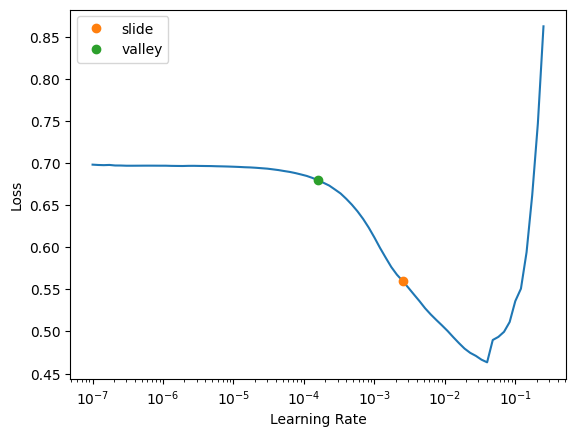

In [45]:
learner.lr_find(suggest_funcs=[slide, valley])

In [46]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.171562,0.166630,0.947605,00:44
1,0.161971,0.159429,0.949195,00:40
2,0.157231,0.155851,0.949025,00:43
3,0.151546,0.154385,0.949365,00:43
4,0.148517,0.153323,0.949985,00:42


In [47]:
learner.save("recipe-classifier-stage-11")

Path('models/recipe-classifier-stage-11.pth')

In [48]:
learner.export("/content/drive/MyDrive/New folder/models/recipe-classifier-stage-11.pkl")

SuggestedLRs(slide=0.0004786300996784121, valley=9.120108734350652e-05)

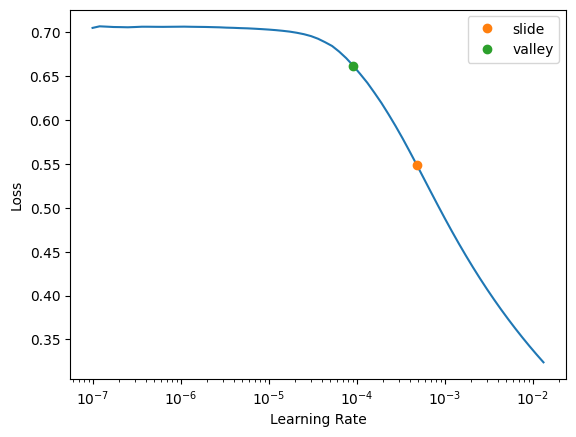

In [ ]:
learner.unfreeze()
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.000595,0.000285,1.000000,01:02
1,0.000075,0.000064,1.000000,01:08
2,0.000038,0.000035,1.000000,01:02
3,0.000029,0.000027,1.000000,01:03
4,0.000027,0.000026,1.000000,00:53


In [ ]:
learner.save("recipe-classifier-stage-9")

In [ ]:
learner.export("/content/drive/MyDrive/New folder/models/recipe-classifier-stage-9.pkl")